# Optimizing Loans’ Parameters to Reduce Associated Risks / Categorizing Low and High Risk Customers 

### SBA Dataset
The SBA dataset contains loan information given by regular banks to small businesses but partially secured by the US government. In the following notebook, I will build a model that predict whether a new loan (based on certain features) will go into default using Random Forests and XGBoost. Furthermore, let’s say this model is deployed as a web app to assist a credit agent, wouldn’t it be nice, given that a customer is categorized as low risk (i.e., the customer will likely not default on the loan), that we could provide the credit agent with the optimal parameter for the loan to increase the likelihood of the loan been paid off? As a second step, I will build a model that can return the optimal term and amount of the loan and let the credit agent decide if the loan should be modified to these values based on the given probabilities.

Dataset can be accessed at: https://www.kaggle.com/datasets/mirbektoktogaraev/should-this-loan-be-approved-or-denied

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import xgboost as xgb
import seaborn as sns
from tqdm import tqdm
import shap
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from pprint import pprint
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Loading the Data
The SBA dataset is available in the CSV format. It is a very large dataset. We are doing to load it and run some quick statistics on it.   

In [9]:
df = pd.read_csv("SBAnational.csv")
df.head(5)

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2.0,0,0,1,0,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,60,2,2.0,0,0,1,0,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,7,1.0,0,0,1,0,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,60,2,1.0,0,0,1,0,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,240,14,1.0,7,7,1,0,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [10]:
df.shape

(899164, 27)

In [11]:
df.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

,count,mean,std,min,25%,50%,75%,max
LoanNr_ChkDgt,899164.00,4772612310.59,2538175037.45,1000014003.00,2589757508.50,4361439006.00,6904626504.75,9996003010.00
Zip,899164.00,53804.39,31184.16,0.00,27587.00,55410.00,83704.00,99999.00
NAICS,899164.00,398660.95,263318.31,0.00,235210.00,445310.00,561730.00,928120.00
Term,899164.00,110.77,78.86,0.00,60.00,84.00,120.00,569.00
NoEmp,899164.00,11.41,74.11,0.00,2.00,4.00,10.00,9999.00
NewExist,899028.00,1.28,0.45,0.00,1.00,1.00,2.00,2.00
CreateJob,899164.00,8.43,236.69,0.00,0.00,0.00,1.00,8800.00
RetainedJob,899164.00,10.80,237.12,0.00,0.00,1.00,4.00,9500.00
FranchiseCode,899164.00,2753.73,12758.02,0.00,1.00,1.00,1.00,99999.00
UrbanRural,899164.00,0.76,0.65,0.00,0.00,1.00,1.00,2.00


In [12]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

### Filtering and Cleaning Data
So, first things first. The dataset contains loans up to 2014. If all loans are kept, we will have a strong bias in the dataset caused by those loans that haven’t reached maturity yet (i.e., the date by which loans are supposed to be fully paid). These loans that have not reached maturity appear to not have defaulted; however, it is impossible to tell if they will actually default in the future since they have not yet been paid in full. So, to begin with, we will calculate the loan maturity year and if this year is greater than 2014, we will drop those loans to avoid introducing bias to the dataset. To accomplish this, we will engineer some features. Moreover, we will be dealing with other issues the dataset has. I will try to explain as best as I can each step.  

In [129]:
# Get date simple fucntion. If simply converted using Pandas datetime functions, Pandas intepret dates like 02-28-79 as if the year was 2079.
def get_date(x):
    if type(x) == float:
        return None
    else:
        date = x.split('-')
        year = date[2] 
        if year == '00':
            year = '20' + year
        elif year == '20':
            year = '20' + '00'
        elif int(year) > 20:
            year = '19' + year
        else:
            year = '20' + year
        return f'{date[0]}-{date[1]}-{year}'

def compare_dates(x):
    approved_date = x['approval_date']
    disbursed_date = x['disbursement_date']
    if approved_date > disbursed_date:
        return approved_date
    else: return disbursed_date

# Convert datetime fields into proper data type and apply get_date function
df['approval_date'] = pd.to_datetime(df['ApprovalDate'].apply(get_date))
df['disbursement_date'] = pd.to_datetime(df['DisbursementDate'].apply(get_date))

#Fixes some inconsistencies I found down the road
# Some loans had earlier disbursement dates compared to the approval dates. That impossible. So, if this happens, we will set the disbursement data equal to the approved date.  
df['disbursement_date'] = df.apply(lambda x: compare_dates(x) if not x['disbursement_date'] is pd.NaT else None, axis=1)

# Convert datetime fields into proper data type and apply get_date function
# I have use new names for this tranformed columns, so I will simply drop the old one later.
df['chg_off_date'] = pd.to_datetime(df['ChgOffDate'].apply(get_date))
df['approved_year'] = df['approval_date'].apply(lambda x: int(x.year))
df['chg_off_year'] = df['chg_off_date'].apply(lambda x: int(x.year) if not x is pd.NaT else None).astype('Int64')

# Drop features that will definetly not be used. 
# DisbursmentData, ApprovalDate and ChgOffDate have been mapped into another features with the proper data type. See Previous lines of code.
# Finally, we are not concerned with the individual names of the credit holders but rather their information. Thus, we will drop the name column. 
df = df.drop(['DisbursementDate', 'ApprovalDate', 'BalanceGross', 'ChgOffDate', 'ApprovalFY'], axis=1) 

# Get disbursement year
df['disbursement_date_year'] = df['disbursement_date'].dt.year.astype('Int64')
# Caclculate the loan maturity date or, put in simple words, the date that the loans are/were expected to be paid.
df['loan_maturity_date'] = df.apply(lambda x: x['disbursement_date'] + pd.DateOffset(months = x['Term']), axis=1)
# Get loan maturity yeay
df['loan_maturity_year'] = df['loan_maturity_date'].dt.year.astype('Int64')

# Since this dataset only tracks loans up to 2014, all loans that extend beyond 2014 and have apparently not defaulted will be droped. Otherwise these entries will \
# produce a strong bias due to those loans that appear to be paid in full but really is just that the dataset doesn't track them any further beyond 2014. 
# As a reuslt, we really have no idea what happened these loans beyond 2014.
# Loans that have defaulted but their loan maturiry date extended beyond 2014 will be keep because we can be certain about the outcome of this loans.
#df = df.drop(df[(df['MIS_Status'] == 'P I F') & (df['loan_maturity_year'] > 2014)].index) #198083 dicarded
# Loans that have no default status and extend beyond 2014 will also be dropped.
df = df.drop(df[(df['MIS_Status'].isnull()) & (df['loan_maturity_year'] > 2014)].index) #242 dicarded
df.head()

,LoanNr_ChkDgt,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,approval_date,disbursement_date,chg_off_date,approved_year,chg_off_year,disbursement_date_year,loan_maturity_date,loan_maturity_year
0,1000014003,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,84,4,2.0,0,0,1,0,N,Y,"$60,000.00",P I F,$0.00,"$60,000.00","$48,000.00",1997-02-28,1999-02-28,NaT,1997,<NA>,1999,2006-02-28,2006
1,1000024006,NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,60,2,2.0,0,0,1,0,N,Y,"$40,000.00",P I F,$0.00,"$40,000.00","$32,000.00",1997-02-28,1997-05-31,NaT,1997,<NA>,1997,2002-05-31,2002
2,1000034009,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,180,7,1.0,0,0,1,0,N,N,"$287,000.00",P I F,$0.00,"$287,000.00","$215,250.00",1997-02-28,1997-12-31,NaT,1997,<NA>,1997,2012-12-31,2012
3,1000044001,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,0,0,1,0,N,Y,"$35,000.00",P I F,$0.00,"$35,000.00","$28,000.00",1997-02-28,1997-06-30,NaT,1997,<NA>,1997,2002-06-30,2002
5,1000084002,PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,120,19,1.0,0,0,1,0,N,N,"$517,000.00",P I F,$0.00,"$517,000.00","$387,750.00",1997-02-28,1997-06-30,NaT,1997,<NA>,1997,2007-06-30,2007


In [130]:
df.shape

(700837, 29)

In the following snippet of code, I will be categorizing the loans that transitioned through the great recession from 2007 through 2009. This feature will help my model quantify the risk associated with a loan defaulting due to a recession. This will be a binary class where 1 means the loan transitioned through a recession and 0 that it didn’t. Being in a recession or close to entering one is something that rarely happens without notice. Thus, it is relatively easy for a credit agent to input this feature based on the current macro status of the us economy. 

Also, we will add one more feature at this point. According to the documentation provided by SBA, if a loan’s term extends beyond 20 years, it must be secured with a collateral (e.g., property). Therefore, we will use this information to engineer a feature that identifies whether a loan was secured.


Finally, we will add one more feature that quantifies the percentage of the final loan that the government secured.  


In [131]:
#The following feature will indicate if the loan was active during the great recession of 2007 and 2009
df['recession'] = df[df['disbursement_date_year'].notnull()].apply(lambda x: 1 if (x['loan_maturity_year'] >= 2007) & (x['disbursement_date_year'] <= 2009) else 0, axis=1).astype('Int64') 

#The following feature will indicate if the loan was secured with property. This is based on the fact that loans with terms equal or greater than 240 must be secured with some sort of realstate according to the owner of the dataset
df['secured_loan'] = df.apply(lambda x: 1 if x['Term'] >= 240 else 0, axis=1)

#Convert the following features into floats
df['DisbursementGross'] = df['DisbursementGross'].apply(lambda x : float(x.replace('$', '').replace(',', '')))
df['SBA_Appv'] = df['SBA_Appv'].apply(lambda x : float(x.replace('$', '').replace(',', '')))
df['GrAppv'] = df['GrAppv'].apply(lambda x : float(x.replace('$', '').replace(',', '')))
df['ChgOffPrinGr'] = df['ChgOffPrinGr'].apply(lambda x : float(x.replace('$', '').replace(',', '')))

#The following feature indicates what percentage of the loan was guaranteed by the goverment
df['%_gov_secured'] = df.apply(lambda x: (x['SBA_Appv'] * 100)/ x['GrAppv'], axis=1)
df.head()

,LoanNr_ChkDgt,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,approval_date,disbursement_date,chg_off_date,approved_year,chg_off_year,disbursement_date_year,loan_maturity_date,loan_maturity_year,recession,secured_loan,%_gov_secured
0,1000014003,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,84,4,2.0,0,0,1,0,N,Y,60000.0,P I F,0.0,60000.0,48000.0,1997-02-28,1999-02-28,NaT,1997,<NA>,1999,2006-02-28,2006,0,0,80.0
1,1000024006,NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,60,2,2.0,0,0,1,0,N,Y,40000.0,P I F,0.0,40000.0,32000.0,1997-02-28,1997-05-31,NaT,1997,<NA>,1997,2002-05-31,2002,0,0,80.0
2,1000034009,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,180,7,1.0,0,0,1,0,N,N,287000.0,P I F,0.0,287000.0,215250.0,1997-02-28,1997-12-31,NaT,1997,<NA>,1997,2012-12-31,2012,1,0,75.0
3,1000044001,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,0,0,1,0,N,Y,35000.0,P I F,0.0,35000.0,28000.0,1997-02-28,1997-06-30,NaT,1997,<NA>,1997,2002-06-30,2002,0,0,80.0
5,1000084002,PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,120,19,1.0,0,0,1,0,N,N,517000.0,P I F,0.0,517000.0,387750.0,1997-02-28,1997-06-30,NaT,1997,<NA>,1997,2007-06-30,2007,1,0,75.0


Here we will be encoding some of the categorical features into numerical ones. This dataset has some weird nomenclature in some of these features that might seem to mean something, but according to SBA (the owner of the dataset), are simply input errors. All these fields are ultimately binary so we will convert them to 1s and 0s and deal will the null values later. 

In [132]:
# Define some converstion fuctions
def convertion_binary(x):
    if x == 1:
        return 0
    elif x == 2:
        return 1
    else:
        return None
    
def yes_no_binary(x):
    if x == 'Y':
        return 1
    elif x == 'N':
        return 0
    else:
        return None

def defaulted(x):
    if x == 'CHGOFF':
        return 1
    elif x == 'P I F':
        return 0
    else:
        return None
    
# Create defaulted feature   
df['defaulted'] = df['MIS_Status'].apply(defaulted).astype('Int64')
# Convert UrbanRural Feature into binary
df['is_rural'] = df['UrbanRural'].apply(convertion_binary).astype('Int64')

# Convert LowDoc and RevLineCr Feature into a binary category. All other anomolies in the entries will be treated as null values.
df['low_doc'] = df['LowDoc'].apply(yes_no_binary).astype('Int64')
df['revolving_credit'] = df['RevLineCr'].apply(yes_no_binary).astype('Int64')

# Convert NewExist into binary
df['NewExist'] = df['NewExist'].astype('Int64').fillna(0)
df['new_business'] = df['NewExist'].apply(convertion_binary).astype('Int64')

# Drop mapped columns
df = df.drop(['UrbanRural', 'MIS_Status', 'LowDoc', 'RevLineCr', 'NewExist'], axis=1) # explain why
df.head()

,LoanNr_ChkDgt,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,DisbursementGross,ChgOffPrinGr,GrAppv,SBA_Appv,approval_date,disbursement_date,chg_off_date,approved_year,chg_off_year,disbursement_date_year,loan_maturity_date,loan_maturity_year,recession,secured_loan,%_gov_secured,defaulted,is_rural,low_doc,revolving_credit,new_business
0,1000014003,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,84,4,0,0,1,60000.0,0.0,60000.0,48000.0,1997-02-28,1999-02-28,NaT,1997,<NA>,1999,2006-02-28,2006,0,0,80.0,0,<NA>,1,0,1
1,1000024006,NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,60,2,0,0,1,40000.0,0.0,40000.0,32000.0,1997-02-28,1997-05-31,NaT,1997,<NA>,1997,2002-05-31,2002,0,0,80.0,0,<NA>,1,0,1
2,1000034009,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,180,7,0,0,1,287000.0,0.0,287000.0,215250.0,1997-02-28,1997-12-31,NaT,1997,<NA>,1997,2012-12-31,2012,1,0,75.0,0,<NA>,0,0,0
3,1000044001,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,0,0,1,35000.0,0.0,35000.0,28000.0,1997-02-28,1997-06-30,NaT,1997,<NA>,1997,2002-06-30,2002,0,0,80.0,0,<NA>,1,0,0
5,1000084002,PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,120,19,0,0,1,517000.0,0.0,517000.0,387750.0,1997-02-28,1997-06-30,NaT,1997,<NA>,1997,2007-06-30,2007,1,0,75.0,0,<NA>,0,0,0


This step is a very important transformation decision I made. The dataset contains a field that indicates whether a loan was given in a rural or urban area. However, the field contains a value to identify “undefined” loans (i.e., it is not known whether the loan was given in an urban area or a rural one). Rather than using unidentified as a class, I will fill these values by using a dataset provided by the US Department of Agriculture that categorizes each zip code/city as urban or rural. To accomplish this, I pre-processed the mentioned dataset in another notebook and then used the zip codes to match those loans that have an “undefined” class. If the zip code didn’t match (which happened a lot because many zip codes have been changed), I used the city name as a last resource to try to find a match. This process can take a will depending on your computer. 

In [133]:
#Convert zip codes into strings
def zips_to_strings(x):
    x = str(x)
    zip_len = len(x)
    missing_zeros = 5- zip_len
    if missing_zeros != 0:
        x = '0'*missing_zeros + x
        return x.strip()
    return x.strip()

# Apply function
df['zip_code'] = df['Zip'].apply(zips_to_strings)

# Load zip code data from the Economic Research Service - U.S. DEPARTMENT OF AGRICULTURE last updated on 2019 regarding the status(i.e., urban or rural) of all zip codes in the USA. 
# Dataset was previously cleaned and transformed to partially match the structure of the SBA dataset and includes zip codes, states and cities features which will be used to match those null values
# in the is_rural feature. 
df_zips = pd.read_csv("zips.csv")
df_zips['zip_code'] = df_zips['zip_code'].apply(zips_to_strings)

# Filter all rows with null values in the is_rural feature. This will considerbly speed up the processing times since the best solution I found to match missing status(i.e., urban or rural)
# was making use of normal for loops since we have to access totally different dataframes.\

df_null = df[df['is_rural'].isnull()].reset_index(drop=True)

# Fix "undefined" values for is_rural feature. Currently there are 264217 missing values and after this process only 1197 remained "undifined"
def is_rural_update(zips = pd.DataFrame, new_zips = pd.DataFrame):
    updated_rows=0
    updated_city=0
    pk_list = zips['LoanNr_ChkDgt'].to_list()
    is_rural = []
    for pk in tqdm(pk_list):
        df = zips[zips.LoanNr_ChkDgt == pk][['zip_code', 'State', 'is_rural', 'City']]
        df_ext = new_zips[new_zips.zip_code == str(df['zip_code'].values[0])][['zip_code', 'state', 'is_rural', 'City']]
        rural = None
        if len(df_ext['zip_code'].values) != 0:
            if  df['zip_code'].values[0] == df_ext['zip_code'].values[0] and df['State'].values[0] == df_ext['state'].values[0]:
                rural = df_ext['is_rural'].values[0]
                updated_rows += 1
        else:
            city_cand = df['City'].values[0]
            state_cand = df['State'].values[0]
            if type(city_cand) != float:
                para_start = city_cand.find('(')
                if para_start != -1:
                    city_cand = city_cand[:para_start]
                city_cand = city_cand.lower().strip()
                city_zip = new_zips[(new_zips['City'] == city_cand) & (new_zips['state'] == state_cand)]['zip_code'].values
                if len(city_zip) > 0:
                    city_zip = city_zip[0]
                    rural = new_zips[new_zips.zip_code == city_zip]['is_rural'].values[0]
                    updated_city += 1

        is_rural.append(rural)
    print(f'{updated_rows} entries were updated from {len(pk_list)} available.')
    print(f'{updated_city} entries were updated using cities from {len(pk_list)} available.')      
    return pd.Series(is_rural)

# Apply function
df_null['is_rural'] = is_rural_update(df_null, df_zips).astype('Int64')
df_null.head()


100%|██████████| 264216/264216 [11:00<00:00, 400.10it/s]


258577 entries were updated from 264216 available.
4442 entries were updated using cities from 264216 available.


,LoanNr_ChkDgt,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,DisbursementGross,ChgOffPrinGr,GrAppv,SBA_Appv,approval_date,disbursement_date,chg_off_date,approved_year,chg_off_year,disbursement_date_year,loan_maturity_date,loan_maturity_year,recession,secured_loan,%_gov_secured,defaulted,is_rural,low_doc,revolving_credit,new_business,zip_code
0,1000014003,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,84,4,0,0,1,60000.0,0.0,60000.0,48000.0,1997-02-28,1999-02-28,NaT,1997,<NA>,1999,2006-02-28,2006,0,0,80.0,0,0,1,0,1,47711
1,1000024006,NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,60,2,0,0,1,40000.0,0.0,40000.0,32000.0,1997-02-28,1997-05-31,NaT,1997,<NA>,1997,2002-05-31,2002,0,0,80.0,0,0,1,0,1,46526
2,1000034009,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,180,7,0,0,1,287000.0,0.0,287000.0,215250.0,1997-02-28,1997-12-31,NaT,1997,<NA>,1997,2012-12-31,2012,1,0,75.0,0,0,0,0,0,47401
3,1000044001,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,0,0,1,35000.0,0.0,35000.0,28000.0,1997-02-28,1997-06-30,NaT,1997,<NA>,1997,2002-06-30,2002,0,0,80.0,0,0,1,0,0,74012
4,1000084002,PLAINVILLE,CT,6062,"TD BANK, NATIONAL ASSOCIATION",DE,332721,120,19,0,0,1,517000.0,0.0,517000.0,387750.0,1997-02-28,1997-06-30,NaT,1997,<NA>,1997,2007-06-30,2007,1,0,75.0,0,0,0,0,0,06062


In [134]:
# Merge together orginal dataframe with the one used to fill the null in the is_rural feature 
df = df.drop(df[df['is_rural'].isnull()].index)
frames = [df, df_null]
df = pd.concat(frames)
df = df.reset_index(drop=True)
# These fields will no longer be needed from this point on.
df = df.drop(['Zip'], axis=1)
df.head()

,LoanNr_ChkDgt,City,State,Bank,BankState,NAICS,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,DisbursementGross,ChgOffPrinGr,GrAppv,SBA_Appv,approval_date,disbursement_date,chg_off_date,approved_year,chg_off_year,disbursement_date_year,loan_maturity_date,loan_maturity_year,recession,secured_loan,%_gov_secured,defaulted,is_rural,low_doc,revolving_credit,new_business,zip_code
0,1000506000,CAMARILLO,CA,WELLS FARGO BANK NATL ASSOC,SD,611110,83,18,5,23,1,438541.0,0.0,100000.0,50000.0,2006-02-07,2006-02-28,NaT,2006,<NA>,2006,2013-01-28,2013,1,0,50.0,0,0,0,1,1,93010
1,1000516003,MIAMI,FL,"CITIBANK, N.A.",FL,238140,84,4,0,4,1,51440.0,0.0,35000.0,17500.0,2006-02-07,2006-02-28,NaT,2006,<NA>,2006,2013-02-28,2013,1,0,50.0,0,0,0,1,0,33186
2,1000526006,NEW ORLEANS,LA,BUSINESS RES. CAP. SPECIALTY B,LA,532490,60,3,0,0,1,50000.0,0.0,50000.0,42500.0,2006-02-07,2006-05-31,NaT,2006,<NA>,2006,2011-05-31,2011,1,0,85.0,0,0,0,0,0,70130
3,1000536009,LEANDER,TX,WELLS FARGO BANK NATL ASSOC,SD,541611,80,2,4,6,1,63076.0,0.0,25000.0,12500.0,2006-02-07,2006-05-31,NaT,2006,<NA>,2006,2013-01-31,2013,1,0,50.0,0,1,0,1,0,78641
4,1000576010,SPRINGFIELD,TN,BBCN BANK,CA,453110,84,4,1,4,1,20000.0,0.0,20000.0,17000.0,2006-02-07,2006-02-28,NaT,2006,<NA>,2006,2013-02-28,2013,1,0,85.0,0,0,0,<NA>,0,37172


## NAICS CODES 
In this section I will be extracting the sector to which the businesses belong to I used the following table provided by the owner of the dataset to do this mapping.  
#### The first two digits of the NAICS classification represent an economic sector.

11 Agriculture, forestry, fishing and hunting

21 Mining, quarrying, and oil and gas extraction

22 Utilities

23 Construction

31–33 Manufacturing

42 Wholesale trade

44–45 Retail trade

48–49 Transportation and warehousing

51 Information

52 Finance and insurance

53 Real estate and rental and leasing

54 Professional, scientific, and technical services

55 Management of companies and enterprises

56 Administrative and support and waste management and remediation services

61 Educational services

62 Health care and social assistance

71 Arts, entertainment, and recreation

72 Accommodation and food services

81 Other services (except public administration)

92 Public administration

In [135]:
#Get the first two digits of the NAICS feature in order to group loans realted to same economic sector
def get_naics(x):
    x = int(str(x)[:2])
    if x == 0:
        return None
    elif 31 <= x <= 33:
        return str(31)
    elif 44 <= x <= 45:
        return str(44)
    elif 48 <= x <= 49:
        return str(48)
    else:
        return str(x)
    
df['econ_sector'] = df['NAICS'].apply(get_naics)
df = df.drop(['NAICS'], axis=1)
df.head()

,LoanNr_ChkDgt,City,State,Bank,BankState,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,DisbursementGross,ChgOffPrinGr,GrAppv,SBA_Appv,approval_date,disbursement_date,chg_off_date,approved_year,chg_off_year,disbursement_date_year,loan_maturity_date,loan_maturity_year,recession,secured_loan,%_gov_secured,defaulted,is_rural,low_doc,revolving_credit,new_business,zip_code,econ_sector
0,1000506000,CAMARILLO,CA,WELLS FARGO BANK NATL ASSOC,SD,83,18,5,23,1,438541.0,0.0,100000.0,50000.0,2006-02-07,2006-02-28,NaT,2006,<NA>,2006,2013-01-28,2013,1,0,50.0,0,0,0,1,1,93010,61
1,1000516003,MIAMI,FL,"CITIBANK, N.A.",FL,84,4,0,4,1,51440.0,0.0,35000.0,17500.0,2006-02-07,2006-02-28,NaT,2006,<NA>,2006,2013-02-28,2013,1,0,50.0,0,0,0,1,0,33186,23
2,1000526006,NEW ORLEANS,LA,BUSINESS RES. CAP. SPECIALTY B,LA,60,3,0,0,1,50000.0,0.0,50000.0,42500.0,2006-02-07,2006-05-31,NaT,2006,<NA>,2006,2011-05-31,2011,1,0,85.0,0,0,0,0,0,70130,53
3,1000536009,LEANDER,TX,WELLS FARGO BANK NATL ASSOC,SD,80,2,4,6,1,63076.0,0.0,25000.0,12500.0,2006-02-07,2006-05-31,NaT,2006,<NA>,2006,2013-01-31,2013,1,0,50.0,0,1,0,1,0,78641,54
4,1000576010,SPRINGFIELD,TN,BBCN BANK,CA,84,4,1,4,1,20000.0,0.0,20000.0,17000.0,2006-02-07,2006-02-28,NaT,2006,<NA>,2006,2013-02-28,2013,1,0,85.0,0,0,0,<NA>,0,37172,44


Next, I will engineer two more features that I believe will greatly improve our predictions. I called them “unemployment_on_loan” and “inflation_on_loan”. Again, just like with the recession feature, I will classify the loans that transition unusual periods of high unemployment and inflation. To do so, I have used official information from the US government regarding unemployment and inflation dating back to 1950 all the way to 2022. Next, for each loan I used the approved year and maturity year feature to get all the unemployment and inflation rates associated to that time frame. If any of those rates are above the average rate calculated using data from 1950 through 2022, then the loan is classified as having transition a high unemployment or inflation period. The average rate for unemployment and inflation was rounded to the nearest highest whole number to create a strong threshold. Just as recession, this is a binary class encoded as 1s and 0s. Furthermore, similarly to recession, these are value that a credit agent can easily produce from quickly analyzing the macro economy of the US.  

### Inflation


In [136]:
# Load dataset with inflation rates for the past 50 years 
df_inflation = pd.read_csv("inflation.csv",).drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], axis=1).T.rename(columns={0: 'inflation'})
df_inflation['inflation'] = df_inflation['inflation'].apply(lambda x: round(x, 2))
df_inflation.index = df_inflation.index.astype(int)
df_inflation.head()

,inflation
1950,1.5
1951,1.1
1952,1.2
1953,1.2
1954,1.3


In [137]:
# There is one(1) loan that in the entire dataset that appears to be defaulted in 1924. This is probably an error since the dataset's description states that only loans from 1987 to 2014 are included, so I will dropped to avoid errors.
df = df.drop(df[df['chg_off_year'] == 1926].index)

In [138]:
# Create a new feature with the inflation rate associated to the year any given loan was defaulted or approved
def get_inflation(x, df_inflation:pd.DataFrame):
    loan_maturity = x['loan_maturity_year']
    approved_year = x['approved_year']
    if loan_maturity is pd.NA or approved_year > loan_maturity:
        loan_maturity = (x['approval_date'] + pd.DateOffset(months = x['Term'])).year
    search_df = df_inflation[(df_inflation.index >= approved_year) & (df_inflation.index <= loan_maturity)]['inflation'].to_list()

    if loan_maturity < approved_year:
        print('Bigger')
        print(x['LoanNr_ChkDgt'])
        print(loan_maturity)
        print(approved_year)

    if len(search_df) == 0:
        print('No data')
        print(x['LoanNr_ChkDgt'])
        print(loan_maturity)
        print(approved_year)

    max_inflation = max(search_df)
    # 3.7 is the average inflation from 1050 to 2021. So, any loan that transitioned through a year of unusually high inflation will be tagged with a different class from those that didn’t. I have rounded the threshold to 4. 
    if max_inflation > 4:
        return 1
    else:
        return 0

df['inflation_on_loan'] = df.apply(lambda x: get_inflation(x, df_inflation), axis=1)
df.head()

,LoanNr_ChkDgt,City,State,Bank,BankState,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,DisbursementGross,ChgOffPrinGr,GrAppv,SBA_Appv,approval_date,disbursement_date,chg_off_date,approved_year,chg_off_year,disbursement_date_year,loan_maturity_date,loan_maturity_year,recession,secured_loan,%_gov_secured,defaulted,is_rural,low_doc,revolving_credit,new_business,zip_code,econ_sector,inflation_on_loan
0,1000506000,CAMARILLO,CA,WELLS FARGO BANK NATL ASSOC,SD,83,18,5,23,1,438541.0,0.0,100000.0,50000.0,2006-02-07,2006-02-28,NaT,2006,<NA>,2006,2013-01-28,2013,1,0,50.0,0,0,0,1,1,93010,61,0
1,1000516003,MIAMI,FL,"CITIBANK, N.A.",FL,84,4,0,4,1,51440.0,0.0,35000.0,17500.0,2006-02-07,2006-02-28,NaT,2006,<NA>,2006,2013-02-28,2013,1,0,50.0,0,0,0,1,0,33186,23,0
2,1000526006,NEW ORLEANS,LA,BUSINESS RES. CAP. SPECIALTY B,LA,60,3,0,0,1,50000.0,0.0,50000.0,42500.0,2006-02-07,2006-05-31,NaT,2006,<NA>,2006,2011-05-31,2011,1,0,85.0,0,0,0,0,0,70130,53,0
3,1000536009,LEANDER,TX,WELLS FARGO BANK NATL ASSOC,SD,80,2,4,6,1,63076.0,0.0,25000.0,12500.0,2006-02-07,2006-05-31,NaT,2006,<NA>,2006,2013-01-31,2013,1,0,50.0,0,1,0,1,0,78641,54,0
4,1000576010,SPRINGFIELD,TN,BBCN BANK,CA,84,4,1,4,1,20000.0,0.0,20000.0,17000.0,2006-02-07,2006-02-28,NaT,2006,<NA>,2006,2013-02-28,2013,1,0,85.0,0,0,0,<NA>,0,37172,44,0


### Unemployment

In [139]:
# Load dataset with unemployment rates for the past 50 years 
df_emp = pd.read_csv("unemployment.csv", usecols=["Year", "Annual"]).set_index('Year').rename(columns={'Annual': 'unemployment'})
df_emp['unemployment'] = df_emp['unemployment'].apply(lambda x: round(x, 2))
df_emp.index = df_emp.index.astype(int)
df_emp.head()

,unemployment
Year,
1950,5.2
1951,3.3
1952,3.0
1953,2.9
1954,5.6


In [140]:
# Create a new feature with the unemployment rate associated to the year any given loan was defaulted or approved
def get_unemployment(x, df_inflation:pd.DataFrame):
    loan_maturity = x['loan_maturity_year']
    approved_year = x['approved_year']
    if loan_maturity is pd.NA:
        loan_maturity = (x['approval_date'] + pd.DateOffset(months = x['Term'])).year
    search_df = df_emp[(df_emp.index >= approved_year) & (df_emp.index <= loan_maturity)]['unemployment'].to_list()
    max_unemployment = max(search_df)
    # 5.7 is the average unemployment from 1050 to 2021. So, any loan that transitioned through a year of unusually high unemployment will be tagged with a different class from those that didn’t. I have rounded the threshold to 6. 
    if max_unemployment > 6:
        return 1
    else:
        return 0

df['unemployment_on_loan'] = df.apply(lambda x: get_unemployment(x, df_emp), axis=1)
df.head()

,LoanNr_ChkDgt,City,State,Bank,BankState,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,DisbursementGross,ChgOffPrinGr,GrAppv,SBA_Appv,approval_date,disbursement_date,chg_off_date,approved_year,chg_off_year,disbursement_date_year,loan_maturity_date,loan_maturity_year,recession,secured_loan,%_gov_secured,defaulted,is_rural,low_doc,revolving_credit,new_business,zip_code,econ_sector,inflation_on_loan,unemployment_on_loan
0,1000506000,CAMARILLO,CA,WELLS FARGO BANK NATL ASSOC,SD,83,18,5,23,1,438541.0,0.0,100000.0,50000.0,2006-02-07,2006-02-28,NaT,2006,<NA>,2006,2013-01-28,2013,1,0,50.0,0,0,0,1,1,93010,61,0,1
1,1000516003,MIAMI,FL,"CITIBANK, N.A.",FL,84,4,0,4,1,51440.0,0.0,35000.0,17500.0,2006-02-07,2006-02-28,NaT,2006,<NA>,2006,2013-02-28,2013,1,0,50.0,0,0,0,1,0,33186,23,0,1
2,1000526006,NEW ORLEANS,LA,BUSINESS RES. CAP. SPECIALTY B,LA,60,3,0,0,1,50000.0,0.0,50000.0,42500.0,2006-02-07,2006-05-31,NaT,2006,<NA>,2006,2011-05-31,2011,1,0,85.0,0,0,0,0,0,70130,53,0,1
3,1000536009,LEANDER,TX,WELLS FARGO BANK NATL ASSOC,SD,80,2,4,6,1,63076.0,0.0,25000.0,12500.0,2006-02-07,2006-05-31,NaT,2006,<NA>,2006,2013-01-31,2013,1,0,50.0,0,1,0,1,0,78641,54,0,1
4,1000576010,SPRINGFIELD,TN,BBCN BANK,CA,84,4,1,4,1,20000.0,0.0,20000.0,17000.0,2006-02-07,2006-02-28,NaT,2006,<NA>,2006,2013-02-28,2013,1,0,85.0,0,0,0,<NA>,0,37172,44,0,1


### Null Value Managment
Let explore the missing values at this point. 


In [141]:
df_nulls = pd.DataFrame(df.isnull().sum(), columns=['null_values',])
df_nulls = df_nulls[df_nulls.null_values != 0]
df_nulls['percentage'] = df_nulls['null_values'].apply(lambda x: round((x/df.shape[0])*100,2))
df_nulls.sort_values('null_values', ascending=False, inplace=True)
df_nulls

,null_values,percentage
chg_off_date,538358,76.82
chg_off_year,538358,76.82
revolving_credit,201318,28.73
econ_sector,163661,23.35
low_doc,3495,0.50
loan_maturity_year,2368,0.34
recession,2368,0.34
loan_maturity_date,2368,0.34
disbursement_date_year,2368,0.34
disbursement_date,2368,0.34


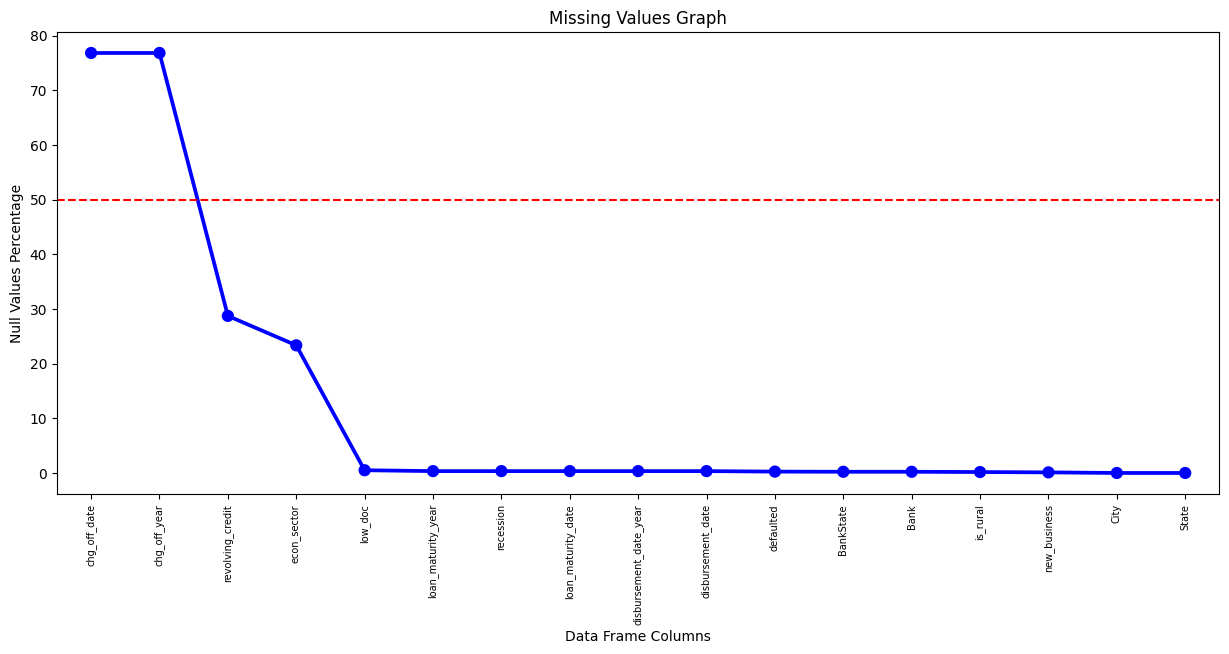

In [142]:
fig = plt.figure(figsize=(15,6))
ax = sns.pointplot(x=df_nulls.index , y=df_nulls['percentage'] , data = df_nulls , color='blue')
plt.xticks(rotation=90,fontsize=7)
ax.axhline(y=50, ls='--',color='red',) 
plt.title("Missing Values Graph")
plt.ylabel("Null Values Percentage")
plt.xlabel("Data Frame Columns")
plt.show()

This dataset requires some prior knowledge about its structure and encoding if one is to make any good predictions out of it. For instance, initially, it appeared as if the feature describing whether a loan was given in a rural or urban area had no null values. However, this feature has been encoded using some sort of label encoding where 0 is undefined, 1 is urban, 2 is rural, and any other number is an entry error. Up to this point, most features have very few data points with null values. So, before I use (if necessary, at all) any inference (e.g., likelihood, random forests, etc..) or value-dropping technique to manage the missing values, we will try to find underlying relationships across the features that might help infer the best fill-up values. For example, the recession feature has been calculated using the dates the loan was disbursed and matured. However, where the disbursement date was missing, it was not possible to get this data. Nonetheless, we can still use the approval date to calculate this field. The approval dates may not be as accurate as the disbursement data since a loan can be approved but disbursed many months later. However, after analyzing the dataset, I can tell that these two dates are usually set apart by only a few days in this dataset. Thus, I consider it a better option to infer these missing values from the approval date rather than from a combination of other features.

Also, at this point, I will drop some fields that I will not be using for my model. All the fields that are related to locations will be dropped except for the state feature. We will not be considering the cities, for example, in which loans have been issued. This is because we can safely assume that geographical, economic, and cultural factors mainly are influenced at a state level rather than at the city one because laws and cultures are mainly defined at the former. Using very specific location or date attributes will cause overfitting since the data points within each location are marginal in comparison to the dataset size.

In [143]:
# Caclculate the loan maturity date or, put in simple words, the date that the loans are/were expected to be paid.
df['loan_maturity_date'] = df.apply(lambda x: (x['approval_date'] + pd.DateOffset(months = x['Term'])) if x['loan_maturity_date'] is pd.NaT else x['loan_maturity_date'], axis=1)
# Get loan maturity year
df['loan_maturity_year'] = df['loan_maturity_date'].dt.year.astype('Int64')

# Get recession null values using approved year rather than disbursment year
def is_recession(x):
    if (x['loan_maturity_year'] >= 2007) & (x['approved_year'] <= 2009):
        return 1
    else: return 0
df['recession'] = df.apply(lambda x: is_recession(x) if x['recession'] is pd.NA else x['recession'], axis=1)

# At this point we can drop all dates as we will not be using them any more. 
# We will not be considering the cities in which loans have been issued. This beacaue we can safely assume that geographical, economical, and cultural factors \
# will affect at a state level rather than at the city one because laws and cultures are mainly defined at former.
df = df.drop(['approval_date', 'disbursement_date', 'loan_maturity_date', 'Bank', 'BankState', 'FranchiseCode', 'loan_maturity_year', 'disbursement_date_year', 'City', 'approved_year', 'chg_off_year', 'chg_off_date', 'zip_code', 'ChgOffPrinGr'], axis=1)

# At this point I will rename some columns to match my preferred naming conventions.
df = df.rename(columns={'LoanNr_ChkDgt':'loan_id', 'State':'state', 'Term':'term', 'NoEmp':'no_emp', 
                        'CreateJob':'created_jobs', 'RetainedJob':'retained_jobs', 'DisbursementGross':'disbursement_gross', 
                        'GrAppv':'gross_appv', 'SBA_Appv':'sba_appv'})

In [144]:
df_nulls = pd.DataFrame(df.isnull().sum(), columns=['null_values',])
df_nulls = df_nulls[df_nulls.null_values != 0]
df_nulls['percentage'] = df_nulls['null_values'].apply(lambda x: round((x/df.shape[0])*100,2))
df_nulls.sort_values('null_values', ascending=False, inplace=True)
df_nulls

,null_values,percentage
revolving_credit,201318,28.73
econ_sector,163661,23.35
low_doc,3495,0.50
defaulted,1755,0.25
is_rural,1197,0.17
new_business,753,0.11
state,14,0.00


In [145]:
# As you can see, we are left with a very little number of null values for most fields. We will drop these values rather than infer them since they are marginal in comparison to the size of the dataset. 
df = df.drop(df[df['defaulted'].isnull()].index)
# Drop all other entries with marginal number of null entries.
df = df.drop(df[df['state'].isnull()].index)
df = df.drop(df[df['new_business'].isnull()].index)
df = df.drop(df[df['is_rural'].isnull()].index)
df = df.drop(df[df['low_doc'].isnull()].index)

In [146]:
# now we have to deal with these two fields that have a large percentage of missing values.
df_nulls = pd.DataFrame(df.isnull().sum(), columns=['null_values',])
df_nulls = df_nulls[df_nulls.null_values != 0]
df_nulls['percentage'] = df_nulls['null_values'].apply(lambda x: round((x/df.shape[0])*100,2))
df_nulls.sort_values('null_values', ascending=False, inplace=True)
df_nulls

,null_values,percentage
revolving_credit,200166,28.86
econ_sector,161944,23.35


So, to fill the missing value for the economic sector each business belongs to, I have hypothesized that there is a strong relationship between the state and the economic sector. We will test this hypothesis in the following section. 

In [147]:
def sector_to_dataframe(df:pd.DataFrame):
    states = df['state'].unique().tolist()
    dic_sector = {}
    for state in states:
        total_business = df[df.state == state]['econ_sector'].value_counts().sum()
        ocurring_sector = df[df.state == state]['econ_sector'].value_counts()[0]
        sector = df[df.state == state]['econ_sector'].value_counts().index[0]
        percentage_ocurring = round((ocurring_sector/total_business)*100,0)
        null_values_state = df[df.state == state]['econ_sector'].isnull().sum() 
        percentage_null = round((null_values_state/(df[df.state == state]['econ_sector'].shape[0]))*100, 0)
        dic_sector[state] = [sector, ocurring_sector, total_business, percentage_ocurring, null_values_state, percentage_null]
    return dic_sector

In [148]:
df_sectors = pd.DataFrame(sector_to_dataframe(df)).T
df_sectors = df_sectors.rename(columns={0:'sector', 1:'num_appearing', 2:'total_appearing', 3:'percentage', 4:'nulls', 5:'nulls_percentage'})
df_sectors.head(50)

,sector,num_appearing,total_appearing,percentage,nulls,nulls_percentage
CA,44,13125,68944,19.0,17327,20.0
FL,44,4553,26783,17.0,4856,15.0
LA,44,1138,5671,20.0,2246,28.0
TX,44,7620,40700,19.0,14750,27.0
TN,44,1183,5468,22.0,1974,27.0
MD,44,1523,8980,17.0,2265,20.0
ME,44,752,3402,22.0,1289,27.0
AK,44,271,1157,23.0,916,44.0
MT,44,1027,4693,22.0,2597,36.0
WA,44,2356,13061,18.0,4791,27.0


I do not feel comfortable replacing the missing values for the economic sector with the most occurring economic sector respective to each business’s state, I believe that building a small model to predict these missing values is the best path forward, let me elaborate on why. So, the missing data points in this field roughly represent 1/6 of all the available data points. If I were to drop the entire field, I would be losing tons of precious data. So, let’s discard that idea. If I fill it up with a new category, let’s say a category that represents “other services”, that would actually be a very bad idea because there is already a category in the NAICS codes that agglomerates these businesses that don’t fall into any other category named “other services”. These missing values are not businesses that belong to the other services category, but rather ones on which there is no data available on the economic sector they belong to. Using "other services" to fill up the missing values will give us a probability of less than 5% of actually guessing the right sector (I say less because obviously, the categories are not equally likely to appear). Finally, using the most occurring sector per state bases will roughly give us a 20% + - probability of guessing the right sector. It is not terrible, but I think there might be a better way. If we look at the correlation heat map in the EDA part of this notebook, we can notice a decent correlation between the term, the percentage secured by the government, and the actual economic sector. Therefore, I try creating a small model to predict the economic sector using term, state, and %_gov_secured as my input features. Let see how it goes. 

In [149]:
# Label Enconde economic sectors
le = LabelEncoder()
le.fit(df['econ_sector'])
df['econ_sector'] = le.transform(df['econ_sector'])

In [150]:
#  Get label econdings for the economic sector
le.transform(['11', '21', '22', '23', '31', '42', '44', '48', '51', '52', '53',
            '54', '55', '56', '61', '62', '71', '72', '81', '92', None])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [151]:
# Label Enconde economic sectors
le2 = LabelEncoder()
le2.fit(df['state'])
df['state'] = le2.transform(df['state'])
le2.transform(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 
              'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME','MI', 'MN', 
              'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM','NV', 'NY', 'OH', 
              'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX','UT', 'VA', 'VT', 'WA', 
              'WI', 'WV', 'WY'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [152]:
df.shape

(693675, 20)

In [148]:
from sklearn.metrics import accuracy_score
df_xgboost = df[['state', 'term', '%_gov_secured', 'econ_sector']]
df_xgboost = df_xgboost[df_xgboost.econ_sector != 22]
print(df_xgboost.shape)
# Splitting data into traning and testing sets.
X, y = df_xgboost.drop(['econ_sector'], axis= 1), df_xgboost['econ_sector']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
df_xgboost.head()

(531731, 4)


,state,term,%_gov_secured,econ_sector
0,4,83,50.0,16
1,9,84,50.0,3
2,18,60,85.0,12
3,43,80,50.0,13
4,42,84,85.0,8


In [149]:
bst = xgb.XGBClassifier().fit(X_train, y_train)
y_pred = bst.predict(X_test)

The results are very disappointing. We have an accuracy of 0.2 which is almost the same as just choosing the most occurring sector per state bases. I will not waste time hyper tunning this model, I will just proceed to use the most occurring sector per sate bases. 

In [150]:
print(accuracy_score(y_pred, y_test))

0.20570396908234365


In [153]:
#Remove Encode 22 and replace it with none
df['econ_sector'] = df.apply(lambda x: None if x['econ_sector'] == 20  else x['econ_sector'], axis=1)

In [154]:
# Re-loead sf_sector dataframe with new label encoding
df_sectors = pd.DataFrame(sector_to_dataframe(df)).T
df_sectors = df_sectors.rename(columns={0:'sector', 1:'num_appearing', 2:'total_appearing', 3:'percentage', 4:'nulls', 5:'nulls_percentage'})
df_sectors['sector'] = df_sectors['sector'].astype('Int64')
df_sectors.head()

,sector,num_appearing,total_appearing,percentage,nulls,nulls_percentage
4,6,242.0,68944.0,0.0,17327.0,20.0
9,6,78.0,26783.0,0.0,4856.0,15.0
18,6,309.0,5671.0,5.0,2246.0,28.0
43,6,303.0,40700.0,1.0,14750.0,27.0
42,6,25.0,5468.0,0.0,1974.0,27.0


In [155]:
# Fill missing values
def new_sector(x, df_sectors:pd.DataFrame):
    state = x['state']
    sector = df_sectors[df_sectors.index == state]['sector'].values[0]
    return sector

df['econ_sector'] = df.apply(lambda x: new_sector(x, df_sectors) if x['econ_sector'] is pd.NA  else x['econ_sector'], axis=1).astype('Int64')
df.head()

,loan_id,state,term,no_emp,created_jobs,retained_jobs,disbursement_gross,gross_appv,sba_appv,recession,secured_loan,%_gov_secured,defaulted,is_rural,low_doc,revolving_credit,new_business,econ_sector,inflation_on_loan,unemployment_on_loan
0,1000506000,4,83,18,5,23,438541.0,100000.0,50000.0,1,0,50.0,0,0,0,1,1,14.0,0,1
1,1000516003,9,84,4,0,4,51440.0,35000.0,17500.0,1,0,50.0,0,0,0,1,0,3.0,0,1
2,1000526006,18,60,3,0,0,50000.0,50000.0,42500.0,1,0,85.0,0,0,0,0,0,10.0,0,1
3,1000536009,43,80,2,4,6,63076.0,25000.0,12500.0,1,0,50.0,0,1,0,1,0,11.0,0,1
4,1000576010,42,84,4,1,4,20000.0,20000.0,17000.0,1,0,85.0,0,0,0,<NA>,0,6.0,0,1


Finally, for the revolving credit field there is no clear path to fill the missing values. It is a shame because I think that it might be a feature that impacts the target variable. Maybe the chances of defaulting on a loan for a business with a revolving credit are different due to the nature of the credit. We will examine this theory before we drop the columns, but ultimately must drop it. 

In [160]:
# Check if the revolving credit field has some correlation to the new business field
df[df.revolving_credit == 1]['new_business'].value_counts()

new_business
0    142733
1     36296
Name: count, dtype: Int64

In [161]:
# Check if the revolving credit field has some correlation to the new business field
df[df.revolving_credit == 0]['new_business'].value_counts()

new_business
0    217209
1     97271
Name: count, dtype: Int64

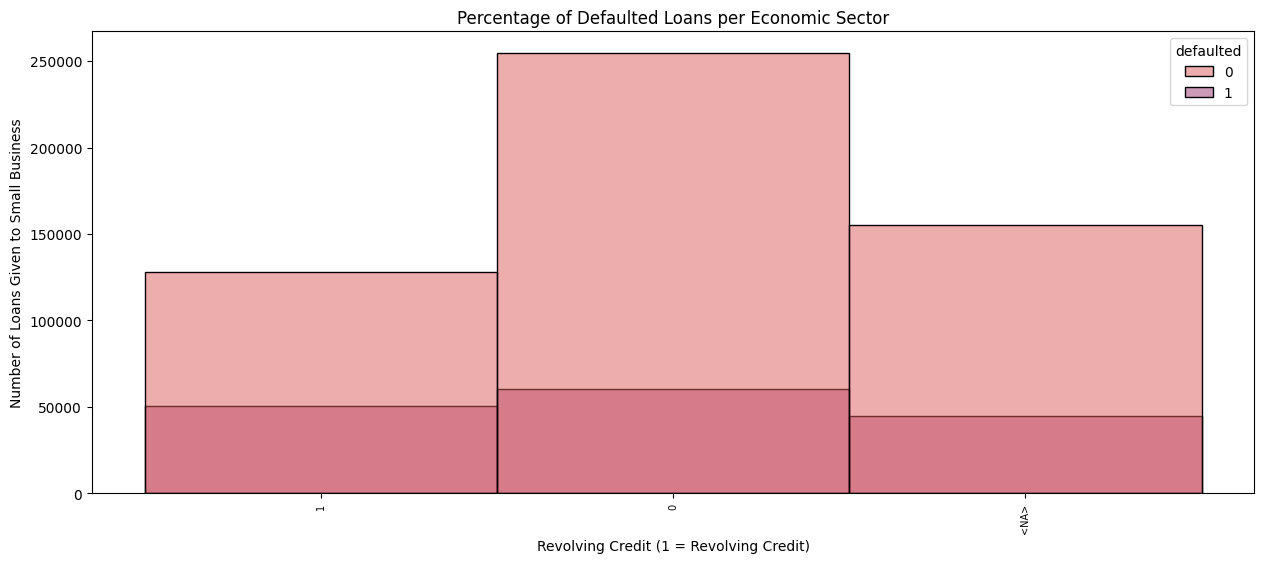

In [162]:
plt.figure(figsize=(15,6))
ax = sns.histplot(df, x= df.revolving_credit.astype(str), hue=df.defaulted.astype(str), palette='flare')
plt.title(label='Percentage of Defaulted Loans per Economic Sector')
plt.ylabel('Number of Loans Given to Small Business')
plt.xlabel('Revolving Credit (1 = Revolving Credit)')
plt.xticks(rotation=90,fontsize=7)
plt.show()

As hypnotized, we can see that credits with no revolving lines are defaulted roughly 33% while those with revolving credits almost reach the 50% mark. 

In [163]:
df = df.drop(columns=['revolving_credit'])

In [164]:
df.head()

,loan_id,state,term,no_emp,created_jobs,retained_jobs,disbursement_gross,gross_appv,sba_appv,recession,secured_loan,%_gov_secured,defaulted,is_rural,low_doc,new_business,econ_sector,inflation_on_loan,unemployment_on_loan
0,1000506000,4,83,18,5,23,438541.0,100000.0,50000.0,1,0,50.0,0,0,0,1,14.0,0,1
1,1000516003,9,84,4,0,4,51440.0,35000.0,17500.0,1,0,50.0,0,0,0,0,3.0,0,1
2,1000526006,18,60,3,0,0,50000.0,50000.0,42500.0,1,0,85.0,0,0,0,0,10.0,0,1
3,1000536009,43,80,2,4,6,63076.0,25000.0,12500.0,1,0,50.0,0,1,0,0,11.0,0,1
4,1000576010,42,84,4,1,4,20000.0,20000.0,17000.0,1,0,85.0,0,0,0,0,6.0,0,1


In [4]:
df_nulls = pd.DataFrame(df.isnull().sum(), columns=['null_values',])
df_nulls = df_nulls[df_nulls.null_values != 0]
df_nulls['percentage'] = df_nulls['null_values'].apply(lambda x: round((x/df.shape[0])*100,2))
df_nulls.sort_values('null_values', ascending=False, inplace=True)
df_nulls

,null_values,percentage


In [169]:
df = df.drop(df[df['term'] == 0].index)

Save data to CVS file for easy reloading

In [5]:
# Save data into a CVS file
df.to_csv('cold_load.csv', index = False)

In [6]:
df = pd.read_csv("cold_load.csv")
df.head(5)

,loan_id,name,state,term,no_emp,created_jobs,retained_jobs,disbursement_gross,gross_appv,sba_appv,approval_date,loan_maturity_date,recession,secured_loan,%_gov_secured,defaulted,is_rural,low_doc,new_business,econ_sector,inflation_on_loan,unemployment_on_loan
0,1000506000,WEYLAND CORPORATION,4,83,18,5,23,438541.0,100000.0,50000.0,2006-02-07,2013-01-28,1,0,50.0,0,0,0,1,14,0,1
1,1000516003,CHICAGO BRICK UNLIMITED INC,9,84,4,0,4,51440.0,35000.0,17500.0,2006-02-07,2013-02-28,1,0,50.0,0,0,0,0,3,0,1
2,1000526006,"RZI, INC.",18,60,3,0,0,50000.0,50000.0,42500.0,2006-02-07,2011-05-31,1,0,85.0,0,0,0,0,10,0,1
3,1000536009,HUTMACHER HOLDINGS INC,43,80,2,4,6,63076.0,25000.0,12500.0,2006-02-07,2013-01-31,1,0,50.0,0,1,0,0,11,0,1
4,1000576010,CORBIN CREEK GREENHOUSE,42,84,4,1,4,20000.0,20000.0,17000.0,2006-02-07,2013-02-28,1,0,85.0,0,0,0,0,6,0,1


### Exploratory Data Analysis (EDA)
Moving on, to have a better understanding of the data, a basic exploratory data analysis process has been performed on the dataset in this section.

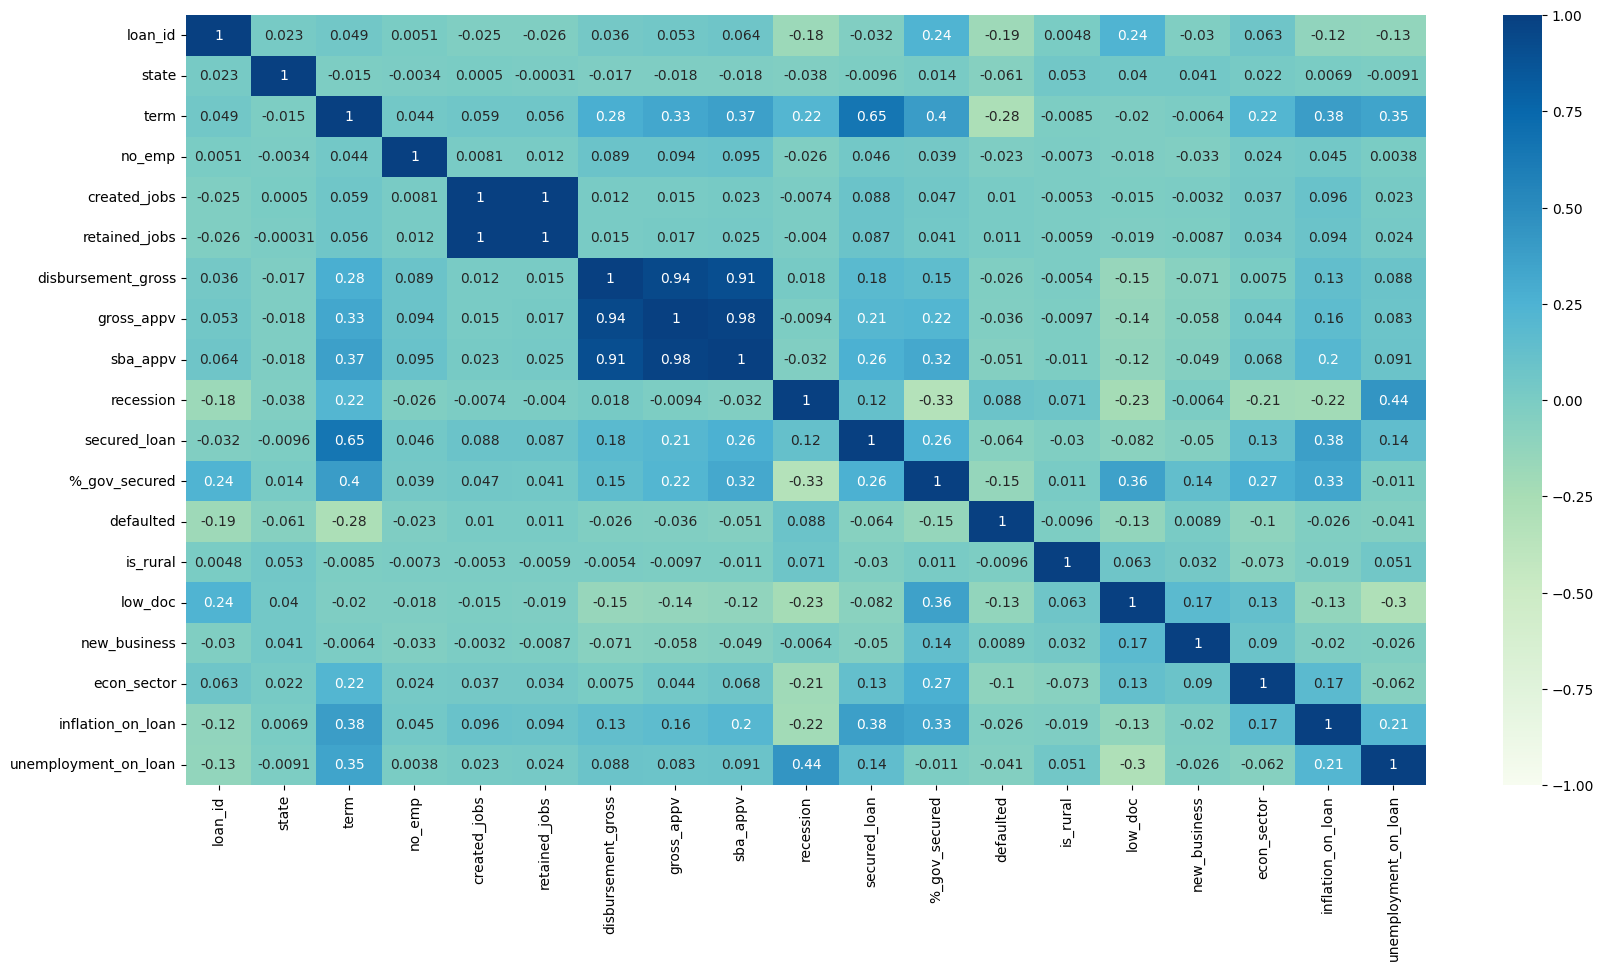

In [212]:
#Check Multicolinearity
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='GnBu', annot=True)
plt.show()

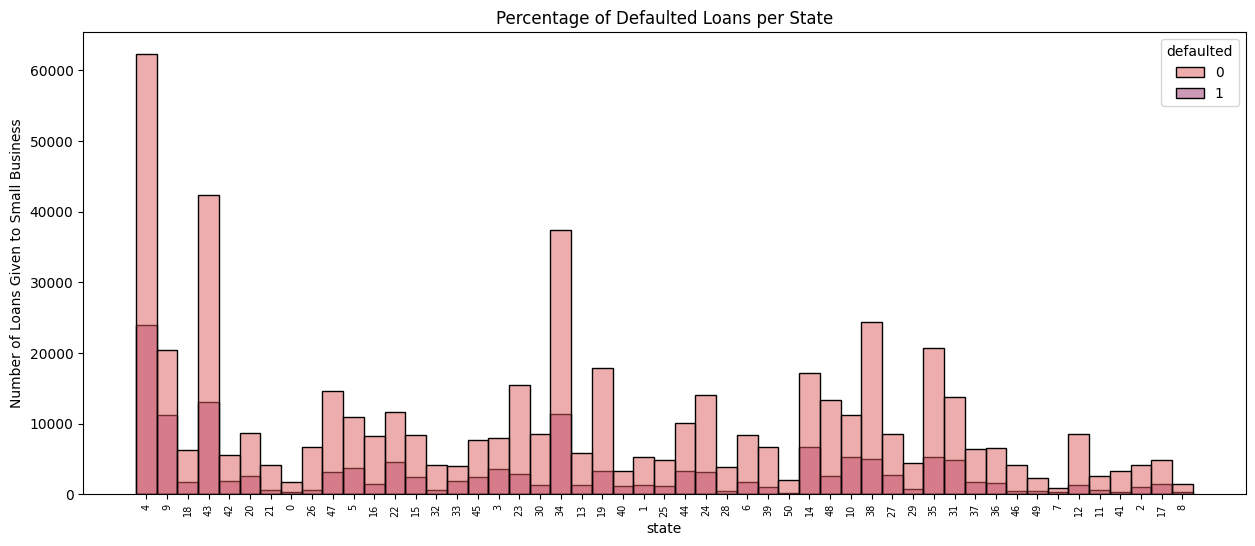

In [217]:
plt.figure(figsize=(15,6))
ax = sns.histplot(df, x= df.state.astype(str), hue=df.defaulted.astype(str), palette='flare')
plt.title(label='Percentage of Defaulted Loans per State')
plt.ylabel('Number of Loans Given to Small Business')
plt.xticks(rotation=90,fontsize=7)
plt.show()

#### State Encoding

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 
              'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME','MI', 'MN', 
              'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM','NV', 'NY', 'OH', 
              'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX','UT', 'VA', 'VT', 'WA', 
              'WI', 'WV', 'WY']
              
[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

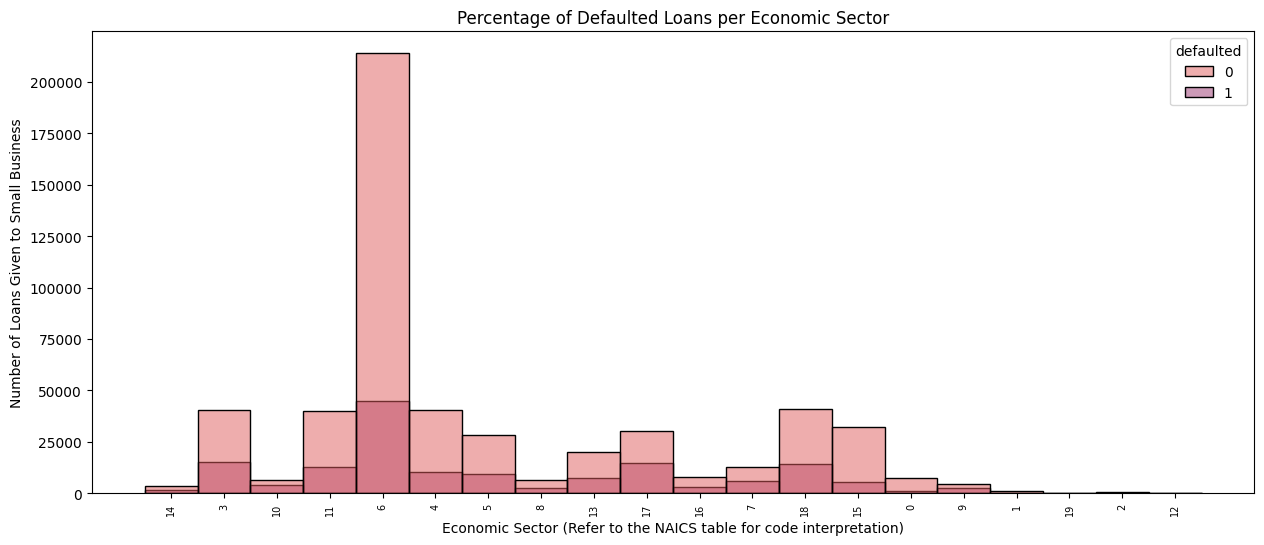

In [177]:
plt.figure(figsize=(15,6))
ax = sns.histplot(df, x= df.econ_sector.astype(str), hue=df.defaulted.astype(str), palette='flare')
plt.title(label='Percentage of Defaulted Loans per Economic Sector')
plt.ylabel('Number of Loans Given to Small Business')
plt.xlabel('Economic Sector (Refer to the NAICS table for code interpretation)')
plt.xticks(rotation=90,fontsize=7)
plt.show()

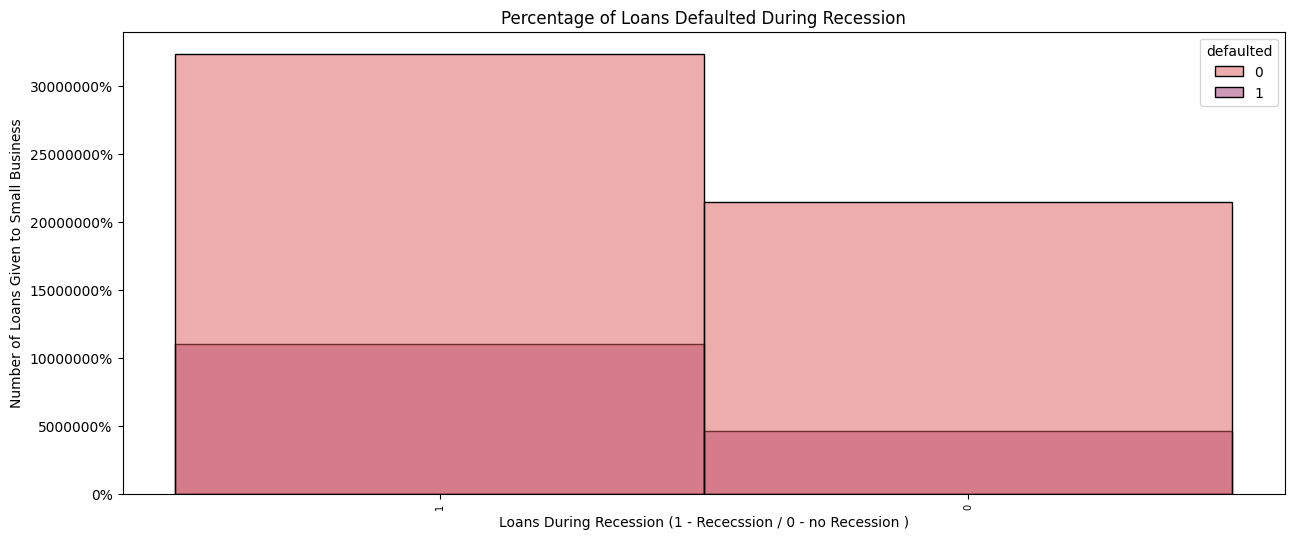

In [214]:
plt.figure(figsize=(15,6))
ax = sns.histplot(df, x= df.recession.astype(str) ,weights=1, hue= df.defaulted.astype(str), palette='flare')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))# check
plt.title(label='Percentage of Loans Defaulted During Recession')
plt.ylabel('Number of Loans Given to Small Business')
plt.xlabel('Loans During Recession (1 - Rececssion / 0 - no Recession )')
plt.xticks(rotation=90,fontsize=7)
plt.show()

### Bulding and testing supervised ML Models
Moving on, to have a better understanding of the data, a basic exploratory data analysis process has been performed on the dataset in this section. After running some code, the key takeaways from this process are the following:

In [3]:
df = pd.read_csv("cleaned_sba.csv")
df.head(5)

,loan_id,state,term,no_emp,created_jobs,retained_jobs,disbursement_gross,gross_appv,sba_appv,recession,secured_loan,%_gov_secured,defaulted,is_rural,low_doc,new_business,econ_sector,inflation_on_loan,unemployment_on_loan
0,1000506000,4,83,18,5,23,438541.0,100000.0,50000.0,1,0,50.0,0,0,0,1,14,0,1
1,1000516003,9,84,4,0,4,51440.0,35000.0,17500.0,1,0,50.0,0,0,0,0,3,0,1
2,1000526006,18,60,3,0,0,50000.0,50000.0,42500.0,1,0,85.0,0,0,0,0,10,0,1
3,1000536009,43,80,2,4,6,63076.0,25000.0,12500.0,1,0,50.0,0,1,0,0,11,0,1
4,1000576010,42,84,4,1,4,20000.0,20000.0,17000.0,1,0,85.0,0,0,0,0,6,0,1


In [4]:
# I have dropped thse columns because after quickly testing them within a simple ML model, they were contributing little to nothing towards predicting the label feature.
df = df.drop(['disbursement_gross', 'loan_id', 'sba_appv'], axis=1)
df.head(5)

,state,term,no_emp,created_jobs,retained_jobs,gross_appv,recession,secured_loan,%_gov_secured,defaulted,is_rural,low_doc,new_business,econ_sector,inflation_on_loan,unemployment_on_loan
0,4,83,18,5,23,100000.0,1,0,50.0,0,0,0,1,14,0,1
1,9,84,4,0,4,35000.0,1,0,50.0,0,0,0,0,3,0,1
2,18,60,3,0,0,50000.0,1,0,85.0,0,0,0,0,10,0,1
3,43,80,2,4,6,25000.0,1,0,50.0,0,1,0,0,11,0,1
4,42,84,4,1,4,20000.0,1,0,85.0,0,0,0,0,6,0,1


In [5]:
# Splitting data into traning and testing sets.
X, y = df.drop(['defaulted'], axis= 1), df['defaulted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

### Random Forest Classifier
We will begin by testing a Random Forest Classifier on the cleaned data. As mentioned before, I expected that all the time spent on cleaning and engineering features for this dataset will pay off by having good or at least decent metrics straight away without the need of hypertunning.

In [224]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred = preds = forest.predict(X_test)

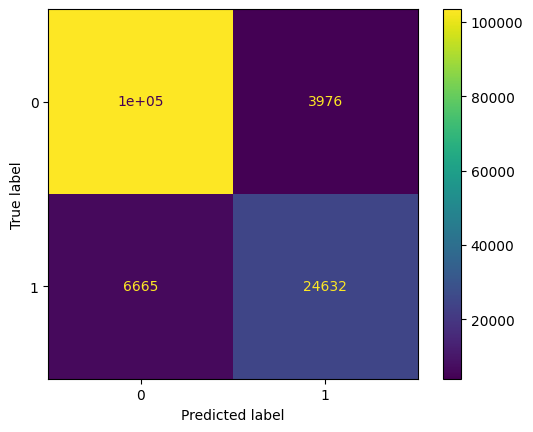

In [225]:
cm = confusion_matrix(y_test, y_pred, labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest.classes_)
disp.plot()

In [226]:
# Get metrics
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95    107438
           1       0.86      0.79      0.82     31297

    accuracy                           0.92    138735
   macro avg       0.90      0.88      0.89    138735
weighted avg       0.92      0.92      0.92    138735



As we can see, we have a very strong model. These metrics are worthy of a production-grade model. We will try improving it by performing a Random Search Grid and a Grid Search. With Random Search I intend to narrow down the search into a manageable range or window of parameters. Then, I will be using Grid Search to exhaustively test parameters within a range established by the best resulting parameters in the Random Search. In this case I will try to optimize for recall since I would rather have customers rejected due to misclassifying them as high risk than having customers default due to having them classified as low risk.

In [4]:
# Intialize Ranfom Forest Classifier
forest = RandomForestClassifier()

# Lets initialized a Random Grid Search to narrow down the options for our hyperparameters
# Check the best number of trees in random forest classifier
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Check the best maximum allowed number of levels in tree 
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Check the best minimum number of samples needed to split a node
min_samples_split = [2, 5, 10]
# Check the best minimum number of samples needed at each leaf node
min_samples_leaf = [1, 2, 5]
# Check if is better to bootstrap of no our traning samples
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Initialize the Randomized Search
# I will be using recall as my scorring metric since I would rather have customers rejected due to misclassifying them as high risk than having customers default due to having them classified as low risk.
rs =RandomizedSearchCV(estimator = forest, 
                           param_distributions = random_grid,
                           scoring='recall',
                           n_iter = 25, 
                           cv = 3, 
                           verbose=3, 
                           random_state=42, 
                           n_jobs = -1,)

# Fit data
rs.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   random_state=42, scoring='recall', verbose=3)

In [5]:
# Best parameters resulted from the grid search
rs.best_params_

{'n_estimators': 350,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 60,
 'bootstrap': False}

In [18]:
# Intialize Ranfom Forest Classifier
forest = RandomForestClassifier()

# Create ranges of parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [40, 60, 80],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 300, 400]
}

# Initialized the grid search model
grid_search = GridSearchCV(estimator = forest,
                           param_grid = param_grid,
                           scoring='recall',
                           cv = 3, 
                           n_jobs = -1, 
                           verbose = 2)

# Fit data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [40, 60, 80],
                         'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 300, 400]},
             scoring='recall', verbose=2)

In [19]:
# Best parameters resulted from the grid search
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [235]:
forest = RandomForestClassifier(n_estimators= 200, 
                                min_samples_split= 5, 
                                min_samples_leaf= 1, 
                                max_features= 'sqrt', 
                                max_depth= 40, 
                                bootstrap= False)
forest.fit(X_train, y_train)
y_pred = preds = forest.predict(X_test)

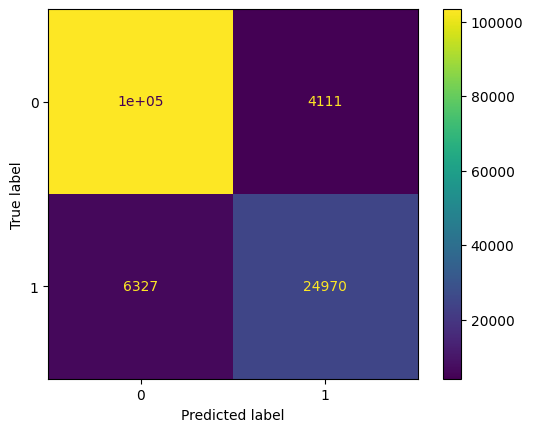

In [236]:
cm = confusion_matrix(y_test, y_pred, labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest.classes_)
disp.plot()

In [237]:
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95    107438
           1       0.86      0.80      0.83     31297

    accuracy                           0.92    138735
   macro avg       0.90      0.88      0.89    138735
weighted avg       0.92      0.92      0.92    138735



Not much improvement from the default parameters for our Random Forest Classifier. However, a slight reduction in the numbers of misclassification can be observed in the confusion matrix. So, we will keep the searched parameters. Moving on, we will quickly generate some visualization to better understand what is going under the model’s hood. 

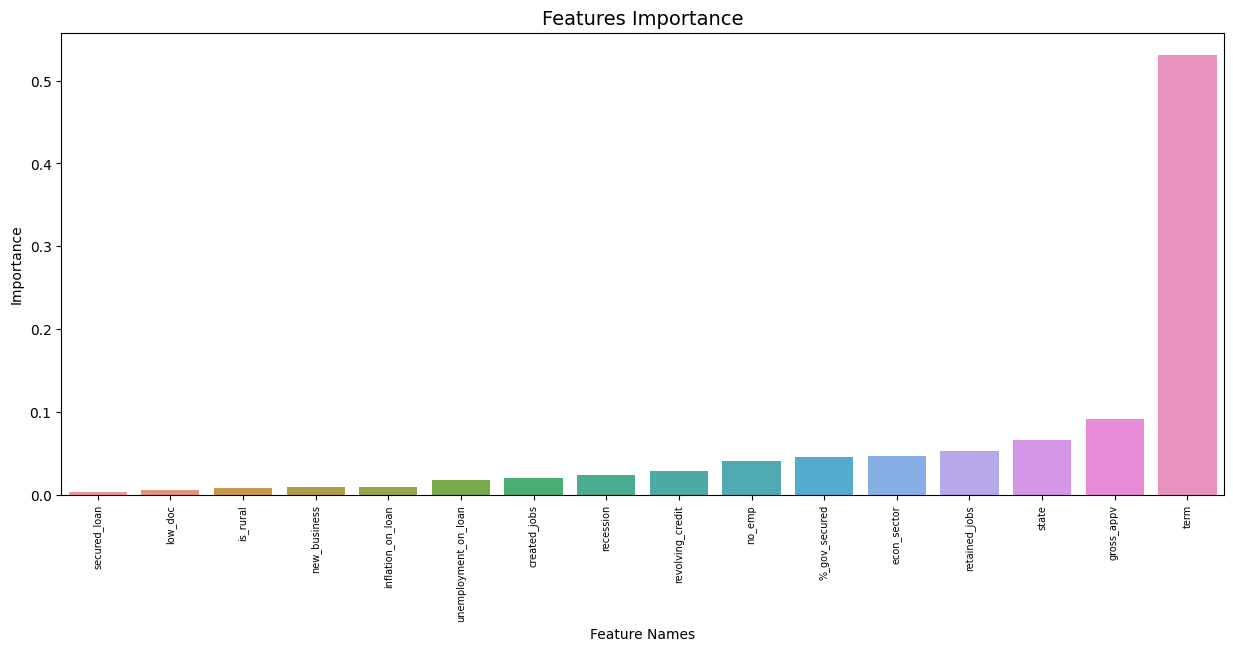

In [47]:
importances_df = pd.DataFrame({"feature_names" : forest.feature_names_in_, 
                               "importances" : forest.feature_importances_}).sort_values(by='importances')
                             
# Plotting bar chart, g is from graph
plt.figure(figsize=(15,6)) 
g = sns.barplot(x=importances_df["feature_names"], 
                y=importances_df["importances"])
plt.xticks(rotation=90,fontsize=7)
plt.xlabel('Feature Names')
plt.ylabel('Importance')
g.set_title("Features Importance", fontsize=14);  

### XGBoost Classifier
Next, we will test XGBoost as a classifier and feature optimizer. When I say feature optimizer, I refer to a model that can output a probability for a loan going into default and thus, giving us the capability of optimizing some feature to reduce this probability. Particularly, the term and gross amount approved features. This process will aid a credit agent not just in defining the level of risk of a customer represents, but also, in the case that the client is of low risk, define what are the best values for the term and gross amount approved to maximize the probability that the customer is going to pay back the loan.

In [6]:
# It is possible to customize objective function with the objective parameter at moment but I will stay with the default
bst = xgb.XGBClassifier() 

search_space = {
    'max_depth': Integer(3,10),
    'min_child_weight': Integer(0, 20),
    'learning_rate': Real(0.05, 1), 
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'colsample_bylevel': Real(0.5, 1.0),
    'colsample_bynode' : Real(0.5, 1.0),
    'alpha': Real(0.0, 10.0),
    'reg_lambda': Real(0.0, 10.0),
    'gamma': Real(0.0, 5),
}

opt = BayesSearchCV(bst, search_space, cv=5, n_iter=50, scoring='recall', random_state=8) 
# in reality, you may consider setting cv and n_iter to higher values

In [7]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                             'learning_rate': Real(low=0.001, high=1, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=0, high=20, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [187]:
opt.best_estimator_

XGBClassifier(alpha=0.0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8283418052168632,
              colsample_bynode=0.9124309155544095,
              colsample_bytree=0.8549189050507754, early_stopping_rounds=None,
              enable_categorical=False, eta=0.36299016897828007,
              eval_metric=None, feature_types=None, gamma=0.0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.0, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=20, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, ...)

In [189]:
# Save model in JSON format
bst = opt.best_estimator_
bst.save_model("loan-predictor.json")

### XGBoost Classifier Metrics 
In the following section we will quicky explore some metrics and visualizations to help us understand the model’s performance and structure.  

In [190]:
bst = xgb.XGBClassifier()
bst.load_model("loan-predictor.json")
y_pred = bst.predict(X_test)

In [191]:
bst = opt.best_estimator_
y_pred = bst.predict(X_test)

In [192]:
# Report
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96    107582
           1       0.86      0.84      0.85     30993

    accuracy                           0.93    138575
   macro avg       0.91      0.90      0.90    138575
weighted avg       0.93      0.93      0.93    138575



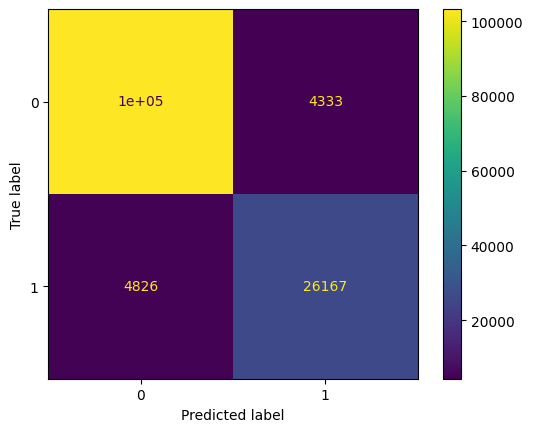

In [193]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=bst.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bst.classes_)
disp.plot()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

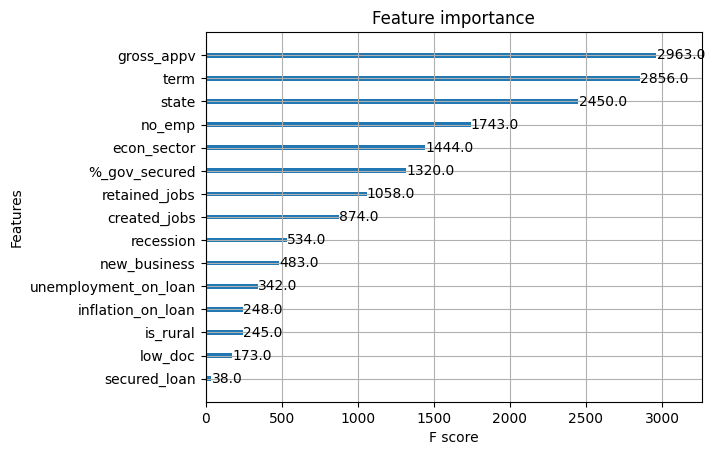

In [194]:
xgb.plot_importance(bst)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


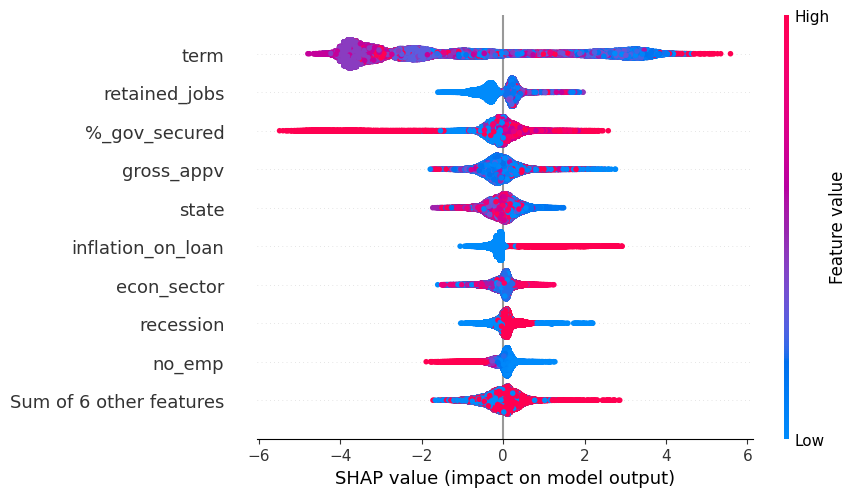

In [195]:
explainer = shap.Explainer(bst)
shap_values = explainer(X_test)
# Summary bee-swarm plot shows the global importance of each feature and the distribution of effect sizes
# Source: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Fitting%20a%20Linear%20Simulation%20with%20XGBoost.html
shap.plots.beeswarm(shap_values)

### Predictions
The following function allows us to test other parameters for any given loan. Specifically, the term and gross amount approved parameters. This function test other parameters within a defined range. Of course, if a customer asks for let’s say a 30000-dollar loan, the bank will not offer the customer a 10000 loan.  It just makes no sense, so this function will only consider a range of 25% more or less gross amount and 50% more and less term. It will return the best parameters and the improved probabilities. 

In [174]:
# New loan parameters
new_loan = {'state': 18,
        'term': 12,
        'no_emp':4,
        'created_jobs':0,
        'retained_jobs': 4,
        'gross_appv':6000,
        'recession':1,
        'secured_loan':	0,
        '%_gov_secured':40.0, 
        'is_rural': 1,
        'low_doc': 1,	
        'new_business': 1,
        'econ_sector': 19, 
        'inflation_on_loan': 0,
        'unemployment_on_loan': 1}
new_loan = pd.DataFrame(new_loan, index=[0])
new_loan.head()

,state,term,no_emp,created_jobs,retained_jobs,gross_appv,recession,secured_loan,%_gov_secured,is_rural,low_doc,new_business,econ_sector,inflation_on_loan,unemployment_on_loan
0,18,12,4,0,4,6000,1,0,40.0,1,1,1,19,0,1


In [175]:
# Check class and probability of belonging to that class of a new loan. 
loan_class = bst.predict(new_loan)[0]
loan_class_prob = bst.predict_proba(new_loan)[0][loan_class]
print(loan_class)
print(loan_class_prob)

0
0.9780186


In [173]:
# Optimizing Fuction
def optimize_loan_parameters(df:pd.DataFrame, bst: xgb.XGBClassifier):
    term = df['term'][0]
    gross_appv = df['gross_appv'][0]
    loan_class = bst.predict(df)[0]
    loan_class_prob = bst.predict_proba(df)[0][loan_class]
    # Adjust second term to expand the testing range
    gross_margin = gross_appv * 0.25
    gross_max_limit = gross_appv + gross_margin
    gross_min_limit = gross_appv - gross_margin
    # Adjust second term to expand the testing range
    term_margin = term * 0.5
    term_max_limit = term+term_margin
    term_min_limit = term-term_margin
    # Is term_min_limit is less than a year, 
    if term_min_limit/12 < 1:
        term_min_limit = term
    test_samples = np.linspace(gross_min_limit, gross_max_limit, 10).round(0).astype(int).tolist()
    # Get gross approved candidate values rounded to the nearest 1000
    test_samples = [int(round((x/1000),0)*1000) for x in test_samples]
    term_samples = np.linspace(term_min_limit, term_max_limit, 10).round(0).astype(int).tolist()
    # Get terms that are only multiples of 12 which mean they are complete years
    term_samples = list(set([int(round((x/12),0)*12) for x in term_samples]))
    combinations = [(x,y) for x in test_samples for y in term_samples]
    num_combinations = [*range(0,len(combinations),1)]
    samples = dict(zip(num_combinations, combinations))
    probabilities = []
    for key in samples:
        test_frame = df
        test_frame['gross_appv'] = samples[key][0] 
        test_frame['term'] = samples[key][1]
        probabilities.append(bst.predict_proba(test_frame)[0][loan_class])
    max_prob = max(probabilities)
    max_prob_index = probabilities.index(max_prob)
    if max_prob > loan_class_prob:
        prob_improv = max_prob - loan_class_prob 
        return (samples[max_prob_index], max_prob, loan_class_prob,prob_improv)
    else:
        return None   

In [147]:
# Returns: ((Optimized Gross Amount Approved, Optimized Term), New probability of belonging to the predicted class, old probability of belonging to the predicted class, difference between both probabilities)
optimize_loan_parameters(new_loan, bst)

((271000, 84), 0.99368334, 0.9854964, 0.008186936)

In [148]:
new_loan

,state,term,no_emp,created_jobs,retained_jobs,gross_appv,recession,secured_loan,%_gov_secured,is_rural,low_doc,new_business,econ_sector,inflation_on_loan,unemployment_on_loan
0,4,60,25,5,30,312000,1,0,60.0,0,0,0,12,1,1


### Conclusions
I will leave it here for now. I would like to mention that while I was playing around with predicting new loans, I saw that the database contains some loans that have very short terms. For example, one month or two months. Moreover, there are some loans that have a 0-month term. This is probably an input error, so it would perhaps be good to get rid of these data points and retrain the model. Of course, it would be nice to have more info from the owner of the dataset, but in this case, we have limited information. Overall, I’m very satisfied with the results. We have a production grade model ready for deployment. The goal of this notebook is to build a Django Application and integrate this model. I will be sharing the link of this app later. 
